# Plot Time Series w/ Observations





## Libraries

In [1]:
####################################################
####################################################
####################################################
#
# Libraries
#

import numpy             as np
import datetime          as datetime
import os                as os
import platform          as platform
import xarray            as xr
import pandas            as pd
import glob              as glob
import siphon.catalog    as siphcat  
import siphon.ncss       as siphncss
import seaborn           as sns
import matplotlib.pyplot as plt
import pint_xarray       as px
import matplotlib.dates  as mdates
import timezonefinder    as tzf
import pytz              as pytz
import haversine         as hs
import socket            as socket
import metpy.calc        as mpcalc
import metpy.units       as mpunits

import matplotlib.font_manager as fm
import matplotlib as mpl

from metpy.units import units




#
####################################################
####################################################
####################################################

## File Organization

In [2]:
####################################################
####################################################
####################################################
#
# File Organization
#

beta_on     = 0
max_domains = 2

if (socket.gethostname() == "kyrill"):
    WRF_OVERALL_DIR = "/projects/SD_Mines_WRF_REALTIME/"
else:
    if (platform.system() == "Darwin"):
         WRF_OVERALL_DIR = "/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/"
    else:
         WRF_OVERALL_DIR = "/home/wjc/GitHub/SD_Mines_WRF_REALTIME/"


os.chdir(WRF_OVERALL_DIR)

print( "Current Working Directory is now " + os.getcwd() )
    
WPS_WORK    = WRF_OVERALL_DIR + "./WPS_PrepArea/"
WPS_EXE     = WRF_OVERALL_DIR + "./WRF4/WPS/"
WRF_EXE     = WRF_OVERALL_DIR + "./WRF4/WRF/test/em_real/"
WRF_ARCHIVE = WRF_OVERALL_DIR + "./ARCHIVE/"
WRF_IMAGES  = WRF_OVERALL_DIR + "./WEB_IMAGES/"



station_list_file = WRF_OVERALL_DIR + "namelist_files_and_local_scripts/time_series_station_files_"+str(max_domains)+"_dom.xlsx"

os.chdir(WRF_EXE)

#
####################################################
####################################################
####################################################

Current Working Directory is now /Users/wjc/GitHub/SD_Mines_WRF_REALTIME


## Time Control

In [3]:
####################################################
####################################################
####################################################
#
# Model Start Date
#

with open(WRF_ARCHIVE  + "./current_complete_run/current_run.txt") as f:
    model_start_date_YYYY_MM_DD_HH = f.readlines()

model_start_date_YYYY_MM_DD_HH     = model_start_date_YYYY_MM_DD_HH[0][0:13]

model_start_date_YYYY_MM_DD_HH0000 = model_start_date_YYYY_MM_DD_HH + ":00:00"
print(model_start_date_YYYY_MM_DD_HH0000)
    
model_start_datetime = datetime.datetime.strptime(model_start_date_YYYY_MM_DD_HH0000, '%Y-%m-%d_%H:%M:%S')
print("Model Simulation Date ", model_start_datetime)
    
model_end_datetime   = model_start_datetime + datetime.timedelta(hours=36)
current_datetime     = datetime.datetime.utcnow()
siphon_end_datetime  = min(current_datetime,model_end_datetime)

print("         Model Start Datetime is ", model_start_datetime)
print("           Model End Datetime is ",   model_end_datetime)
print("             Current Datetime is ",     current_datetime)
print("          Siphon End Datetime is ",  siphon_end_datetime)

#
####################################################
####################################################
####################################################

2021-10-23_12:00:00
Model Simulation Date  2021-10-23 12:00:00
         Model Start Datetime is  2021-10-23 12:00:00
           Model End Datetime is  2021-10-25 00:00:00
             Current Datetime is  2021-10-23 22:59:51.664344
          Siphon End Datetime is  2021-10-23 22:59:51.664344


## Read tslist excel file



In [6]:
####################################################
####################################################
####################################################
#
# Read TSLIST Excel File
#

print("read file from "+station_list_file)

available_time_series_list = pd.read_excel(station_list_file,
                                           index_col=0)

print(available_time_series_list)

#
####################################################
####################################################
####################################################

read file from /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/namelist_files_and_local_scripts/time_series_station_files_2_dom.xlsx
   Station ID  Domain            Station Name  Latitude  Longitude
26       KUNR       2      Rapid City NWS, SD   44.0727   -103.211
20       KRAP       2  Rapid City Airport, SD   44.0430   -103.054
21       KRCA       2       Ellsworth AFB, SD   44.1330   -103.100
25       KUDX       2   Rapid City NEXRAD, SD   44.1330   -102.833
23       KSPF       2     Clyde Ice Field, SD   44.4830   -103.783
7        KCUT       2              Custer, SD   43.7330   -103.611
15       KIEN       2          Pine Ridge, SD   43.0210   -102.518
18       KPHP       2              Philip, SD   44.0510   -101.601
30       MUNS       1              Munich, ND   48.6667    -98.835
0        K2WX       2             Buffalo, SD   45.6040   -103.546
6        KCDR       2             Chadron, NE   42.8370   -103.098
19       KPIR       2              Pierre, SD   44.3810   -100.286
11  

## Rotate through Available Files

Creating /Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./WEB_IMAGES/./current_complete_run/STATION_TIME_SERIES/
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2021-10-23_12_KUNR.nc


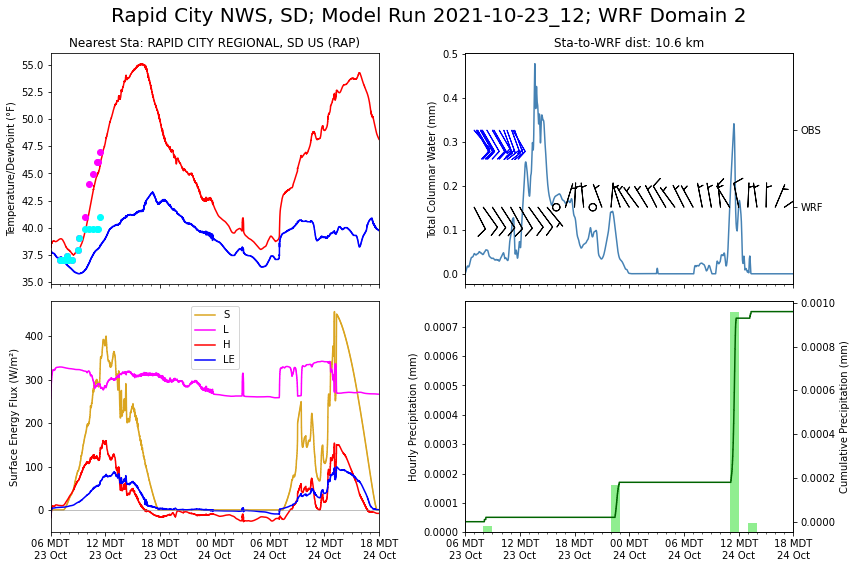

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2021-10-23_12_KRAP.nc


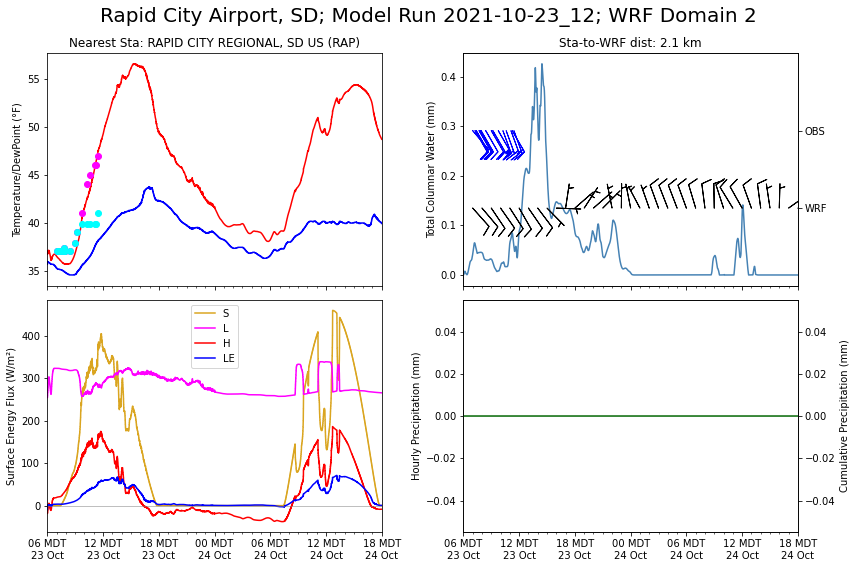

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2021-10-23_12_KRCA.nc


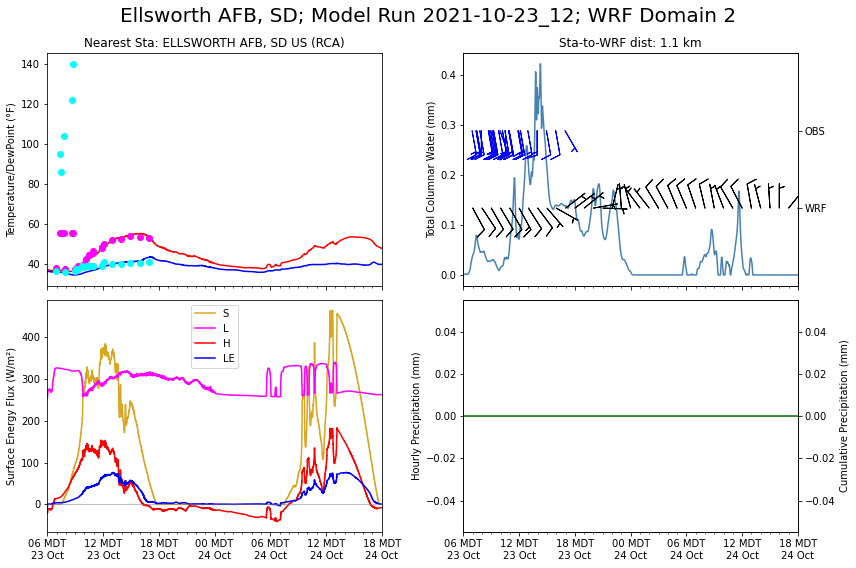

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2021-10-23_12_KUDX.nc


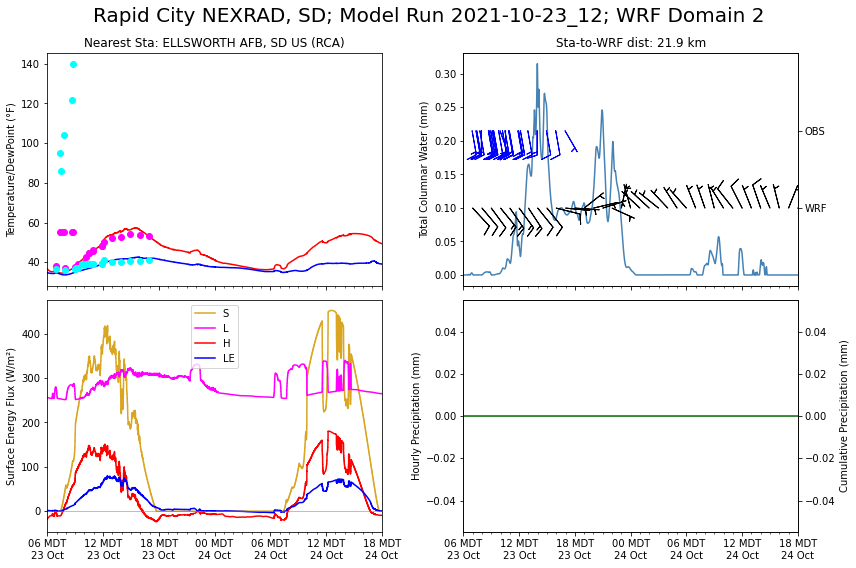

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2021-10-23_12_KSPF.nc


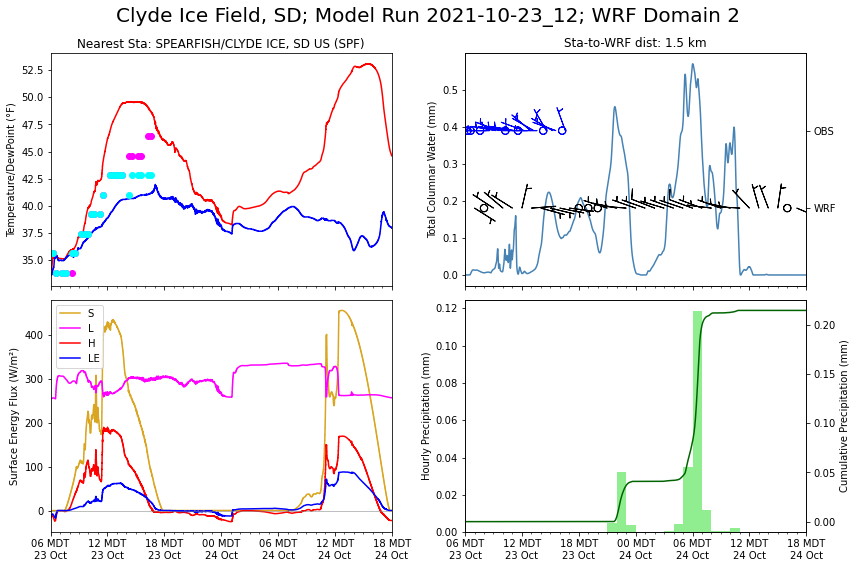

 
/Users/wjc/GitHub/SD_Mines_WRF_REALTIME/./ARCHIVE/./current_complete_run/STATION_TIME_SERIES/./wrfout_d02_2021-10-23_12_KCUT.nc


HTTPError: Error accessing https://thredds.ucar.edu/thredds/ncss/nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr?var=report_length&var=weather&var=wind_from_direction&var=air_temperature&var=precipitation_amount_hourly&var=hectoPascal_ALTIM&var=report&var=dew_point_temperature&var=air_pressure_at_sea_level&var=cloud_area_fraction&var=numChildren&var=wind_speed&var=precipitation_amount_24&var=report_id&time_start=2021-10-23T12%3A00%3A00&time_end=2021-10-23T22%3A59%3A51.664344&longitude=-103.609&latitude=43.738&accept=netcdf
Server Error (400: in define mode)

In [8]:
####################################################
####################################################
####################################################
#
# Rotate through Available Files
#

file_time = model_start_datetime.strftime('%Y-%m-%d_%H')

TS_DIR    = WRF_ARCHIVE  + "./current_complete_run/STATION_TIME_SERIES/"

#
# Creating Graphics Directory
#

graphics_directory = WRF_IMAGES + "./current_complete_run/STATION_TIME_SERIES/"

print("Creating " + graphics_directory)

os.system("mkdir -pv " + graphics_directory )

#
# Start File Rotation
#

for station in available_time_series_list.iterrows():

    ###################################################################
    #
    # Pull Station Data 
    #

    station_id     = station[1][0]
    grid_domain    = station[1][1]
    station_name   = station[1][2]
    station_lat    = station[1][3]
    station_lon    = station[1][4]

    #    
    ###################################################################

    ###################################################################
    #
    # Pull WRF Time Series
    #
    
    netcdf_file_name = TS_DIR + "./wrfout_d"+str(grid_domain).zfill(2)+"_"+file_time+"_"+station_id+".nc"
    
    wrf_timeseries = xr.open_dataset(netcdf_file_name, 
                                     engine='netcdf4')
    
    print(netcdf_file_name)

    #
    ###################################################################

    ###################################################################
    #
    # Pull NCSS Realtime Obs
    #

    #
    # Source Data Server
    #

    metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

    metar_cat = siphcat.TDSCatalog(metar_cat_url)

    dataset = list(siphcat.TDSCatalog(metar_cat_url).datasets.values())[0]

    ncss_url = dataset.access_urls["NetcdfSubset"]

    ncss = siphncss.NCSS(ncss_url)

    #
    # çonstruct query
    #

    query = ncss.query()
    query.lonlat_point(wrf_timeseries["wrf_grid_longitude"].values, 
                       wrf_timeseries["wrf_grid_latitude"].values)

    query.time_range(model_start_datetime, siphon_end_datetime)

    query.variables('air_pressure_at_sea_level',
                    'air_temperature',
                    'cloud_area_fraction',
                    'dew_point_temperature',
                    'hectoPascal_ALTIM',
                    'numChildren',
                    'precipitation_amount_24',
                    'precipitation_amount_hourly',
                    'report',
                    'report_id',
                    'report_length',
                    'weather',
                    'wind_from_direction',
                    'wind_speed')
    query.accept('netcdf')

    #
    # Pull Querry
    # 

    ncss_xarray_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(ncss.get_data(query)))
    ncss_xarray_dataset = ncss_xarray_dataset.sortby(["time"])
    
    metar_station_name = ncss_xarray_dataset["station_description"].values
    metar_station_ata  = ncss_xarray_dataset["station_id"].values
    
    metar_latitude  = ncss_xarray_dataset["latitude"].values
    metar_longitude = ncss_xarray_dataset["longitude"].values
    
    metar_to_sta_distance  = hs.haversine((metar_latitude,
                                           metar_longitude),
                                          (station_lat,
                                           station_lon))
    
    metar_to_wrf_distance = hs.haversine((metar_latitude,
                                          metar_longitude),
                                         (wrf_timeseries["wrf_grid_latitude"].values,
                                          wrf_timeseries["wrf_grid_longitude"].values))
    

    sta_to_wrf_distance   = hs.haversine((station_lat,
                                          station_lon),
                                         (wrf_timeseries["wrf_grid_latitude"].values,
                                          wrf_timeseries["wrf_grid_longitude"].values))

    #
    ###################################################################    
    

    ###################################################################
    ###################################################################
    #
    # Create Meteogram
    #

    ###################################################################
    #
    # Time Axes
    #
                                         
    tf     = tzf.TimezoneFinder()
    tz     = tf.certain_timezone_at(lng=station_lon, lat=station_lat)
    
    tzabbr = pytz.timezone(tz).localize(model_start_datetime)

    wrf_times  = pd.to_datetime(wrf_timeseries["time"]).tz_localize(tz="UTC").tz_convert(tz=tz)
    ncss_times = pd.to_datetime(ncss_xarray_dataset["time"]).tz_localize(tz="UTC").tz_convert(tz=tz)


    wrf_time_seconds =  wrf_times.minute*60+wrf_times.second 
    on_the_hour      = np.where(wrf_time_seconds ==0)
    wrf_time_hrly    = wrf_times[on_the_hour]
    wrf_time_hrly_bar = wrf_times[on_the_hour]-datetime.timedelta(minutes=30)

    #
    ###################################################################


    ###################################################################
    #
    # Precip Prep
    #

    wrf_cum_prec      = wrf_timeseries["stratiform_precipitation_amount"].values + wrf_timeseries["convective_precipitation_amount"].values
    wrf_cum_hrly_prec = wrf_cum_prec[on_the_hour]
    wrf_hrly_prec     = wrf_cum_hrly_prec.copy()

    wrf_hrly_prec[1:] = wrf_cum_hrly_prec[1:] - wrf_cum_hrly_prec[0:-1]

    #
    ###################################################################

    ###################################################################
    #
    # Wind Barb Prep
    #

    u_wrf = (wrf_timeseries["eastward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]
    v_wrf = (wrf_timeseries["northward_wind_10m"]*units("m")/units("s")).pint.to("knots")[on_the_hour]

    obs_winddir   = ncss_xarray_dataset["wind_from_direction"] * units.deg
    obs_windspeed = ( ncss_xarray_dataset["wind_speed"] * units("m")/units("s")).pint.to("knots") 

    u_obs, v_obs =  mpcalc.wind_components(obs_windspeed, obs_winddir) 

    #
    ###################################################################

    ###################################################################
    #
    # Plot Meteogram
    #

    fig, ax = plt.subplots(figsize = (12, 8),
                           nrows   =  2, 
                           ncols   =  2,
                           sharex  =  True)

    date_form = mdates.DateFormatter("%H %Z\n%d %b", tz=pytz.timezone(tz))
    xmajor = mdates.HourLocator(interval = 6)
    xminor = mdates.HourLocator(interval = 1)

    #
    # Temperature and Humidity
    #
    
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["air_temperature_2m"]*units("K")).pint.to("degF"),
              color = "red")
    ax[0,0].plot(wrf_times,
             (wrf_timeseries["dew_point_temperature_2m"]*units("K")).pint.to("degF"),
              color = "blue")

    ax[0,0].plot(ncss_times,
             (ncss_xarray_dataset["air_temperature"]*units("degC")).pint.to("degF"),
             marker = "o",
             color="magenta",
            linestyle = "None")
    ax[0,0].plot(ncss_times,
             (ncss_xarray_dataset["dew_point_temperature"]*units("degC")).pint.to("degF"),
             marker = "o",
             color="cyan",
            linestyle = "None")
    ax[0,0].set_ylabel("Temperature/DewPoint (°F)")
    ax[0,0].set_title("Nearest Sta: "+metar_station_name[0].astype('U') +" ("+metar_station_ata[0].astype('U') +")")
    ax[0,1].set_title("Sta-to-WRF dist: "+str(round(metar_to_wrf_distance,1)) +" km")


    #
    # Total Atmos Column Water + Wind Speed
    #
    
    ax[0,1].plot(wrf_times,
            wrf_timeseries["atmosphere_mass_content_of_water"],
              color = "steelblue")
    ax[0,1].set_ylabel("Total Columnar Water (mm)")
 

    ax01 = ax[0,1].twinx()
    
    ax01.set_ylim(0,1)
    ax01.set_yticks([1/3.,2/3.])
    ax01.set_yticklabels(["WRF","OBS"])

    ax01.barbs( wrf_time_hrly, 1/3.,  u_wrf, v_wrf )
    ax01.barbs( ncss_times,    2/3.,  u_obs, v_obs, color="blue")

   
    
    #
    # Surface Energy Budget
    #

    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_shortwave_flux"],
                 color = "goldenrod")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_net_downward_longwave_flux"],
                 color = "magenta")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_sensible_heat_flux"],
                 color = "red")
    ax[1,0].plot(wrf_times,
                 wrf_timeseries["surface_upward_latent_heat_flux"],
                 color = "blue")
    ax[1,0].legend(["S","L","H","LE"])
    ax[1,0].set_ylabel("Surface Energy Flux (W/m²)")

    ax[1,0].axhline(y=0,color="grey", linewidth=0.5)
 
    #
    # Precipitation
    #

    ax[1,1].bar(wrf_time_hrly_bar,
                wrf_hrly_prec,
                linewidth=0,
                width=1/24, 
                color="lightgreen",
                edgecolor=None)
    ax11 = ax[1,1].twinx()
    ax11.plot(wrf_times,
              wrf_cum_prec, 
              color="darkgreen")
    ax11.set_ylabel("Cumulative Precipitation (mm)")
    ax[1,1].set_ylabel("Hourly Precipitation (mm)")

    fig.suptitle(station_name+"; Model Run "+file_time+"; WRF Domain "+str(grid_domain),
                 fontsize=20)


    ax[1,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,0].xaxis.set_major_formatter(date_form)
    ax[1,0].xaxis.set_major_locator(xmajor)
    ax[1,0].xaxis.set_minor_locator(xminor)
    ax[1,0].xaxis_date()

    ax[1,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[1,1].xaxis.set_major_formatter(date_form)
    ax[1,1].xaxis.set_major_locator(xmajor)
    ax[1,1].xaxis.set_minor_locator(xminor)
    ax[1,1].xaxis_date()

    ax[0,0].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,0].xaxis.set_major_formatter(date_form)
    ax[0,0].xaxis.set_major_locator(xmajor)
    ax[0,0].xaxis.set_minor_locator(xminor)
    ax[0,0].xaxis_date()

    ax[0,1].set_xlim(model_start_datetime, model_end_datetime)
    ax[0,1].xaxis.set_major_formatter(date_form)
    ax[0,1].xaxis.set_major_locator(xmajor)
    ax[0,1].xaxis.set_minor_locator(xminor)
    ax[0,1].xaxis_date()


    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)


    # plt.show()
    if (platform.system() != "Darwin"):
        fig.savefig(graphics_directory + "./wrfout_dxx_"+file_time+"_"+station_id+".png")
    else:
        plt.show()

    plt.close('all')


    #
    ###################################################################

    #
    ###################################################################
    ###################################################################
    
    print(" ")



## Depart 

In [ ]:
####################################################
####################################################
####################################################
#
# End of Script
#

print("Ploting Meteogram Script complete.")

#
####################################################
####################################################
####################################################